# Forecast IC-capacity for the next year
---

In [1]:
# Importeren van de benodigde libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns # Kan mogelijk weg.
from os import path, getcwd
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pmd
import statsmodels.api as sm

# Negeren van filterwarnings
warnings.filterwarnings("ignore")

## Inladen van de benodigde datasets
---

In [2]:
# Dataset path
root_dir = path.join(getcwd(), 'Datasets')

# Inlezen benodigde CSV-bestanden
df_per_dag = pd.read_csv(path.join(root_dir, "data_per_dag.csv"))
df_per_leeftijd = pd.read_csv(path.join(root_dir, "data_per_leeftijd.csv"))

# Eerste week van df_per_dag halen, zodat de tijdranges in beide datasets overeen komen.
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
df_per_dag = df_per_dag.loc[(df_per_dag["Date_adj"] >= "2020-04-01") & (df_per_dag["Date_adj"] < "2021-11-01")]

df_per_dag.head(5)

,Aanwezig op IC verdacht of bewezen Corona,Aanwezig op verpleegafdeling verdacht of bewezen Corona,Opname IC Corona,Opname IC verdacht,Opname IC totaal,Opname verpleegafdeling Corona,Opname verpleegafdeling verdacht,Opname verpleegafdeling totaal,Date_adj,Infection
1,231,1175,23,0,23,130,3,133,2021-10-31,8823
2,222,1119,13,0,13,139,2,141,2021-10-30,8504
3,234,1101,27,0,27,157,2,159,2021-10-29,8440
4,220,1026,23,0,23,136,6,142,2021-10-28,7946
5,216,965,21,0,21,145,5,150,2021-10-27,8499


In [3]:
# Set index dataset

df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
Index_df_per_dag = df_per_dag[["Aanwezig op IC verdacht of bewezen Corona", "Date_adj"]]
Index_df_per_dag.set_index(["Date_adj"], inplace=True)

Index_df_per_dag

,Aanwezig op IC verdacht of bewezen Corona
Date_adj,
2021-10-31,231
2021-10-30,222
2021-10-29,234
2021-10-28,220
2021-10-27,216
...,...
2020-04-05,1312
2020-04-04,1285
2020-04-03,1279


In [4]:
# Replace daily numbers with montly averages
#Index_df_per_dag["IC-capaciteit_log"] = np.log(Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"])
Index_df_per_dag = Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"].resample("W").max()

Index_df_per_dag


Date_adj
2020-04-05    1312
2020-04-12    1321
2020-04-19    1228
2020-04-26    1020
2020-05-03     787
              ... 
2021-10-03     164
2021-10-10     143
2021-10-17     150
2021-10-24     196
2021-10-31     234
Freq: W-SUN, Name: Aanwezig op IC verdacht of bewezen Corona, Length: 83, dtype: int64

## Verdelen van de dataset in een train- en testset.
---

In [5]:
train = Index_df_per_dag[:63]
test = Index_df_per_dag[63:]
len(Index_df_per_dag)

83

# Building the ARIMA-model
---
1. p-value bepalen met behulp van de Augmented Dickey Fuller test.
2. Predict p, q and d
3. Build model
4. Visualize model
5. Evaluate model

p-value: 0.000097


<AxesSubplot:xlabel='Date_adj'>

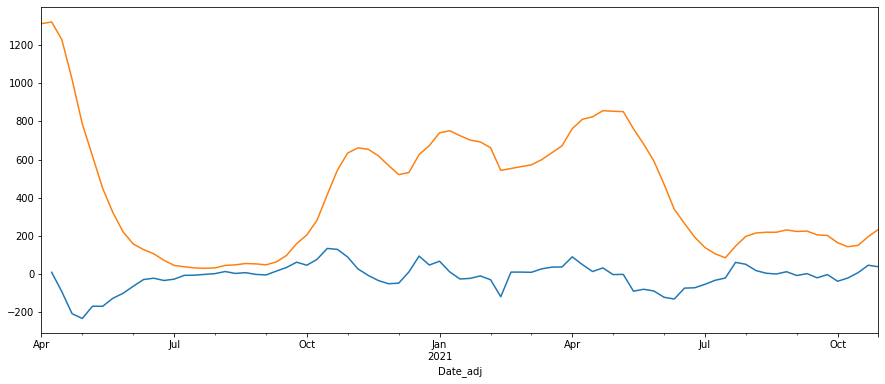

In [6]:
# Get P-value
diff_1 = Index_df_per_dag.diff(1).dropna()
result = adfuller(Index_df_per_dag)
print("p-value: %f" % result[1])

diff_1.plot(figsize=(15,6))
Index_df_per_dag.plot()

Uit de resultaten van bovenstaande cel blijkt de p-value, die de stationary van de data weergeeft, pas na een diff toe te passen op een waarde onder de 0,05 uit te komen. Hieruit kan geconcludeerd worden dat de d binnen het Arima-model de waarde **0** zou moeten krijgen.

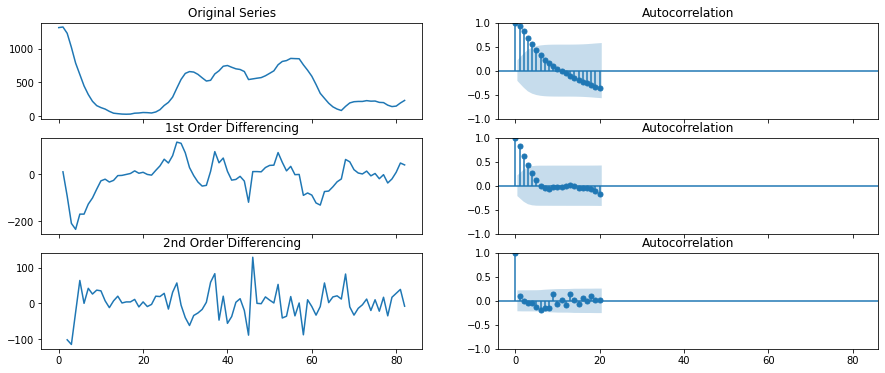

In [7]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(15,6))
axes[0, 0].plot(Index_df_per_dag.values); axes[0, 0].set_title('Original Series')
plot_acf(Index_df_per_dag, ax=axes[0, 1])


# 1st Differencing
axes[1, 0].plot(Index_df_per_dag.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(Index_df_per_dag.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(Index_df_per_dag.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(Index_df_per_dag.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

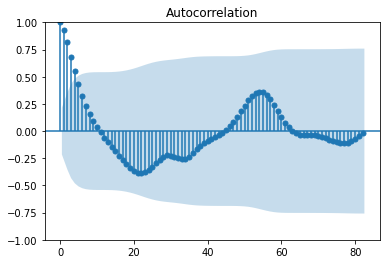

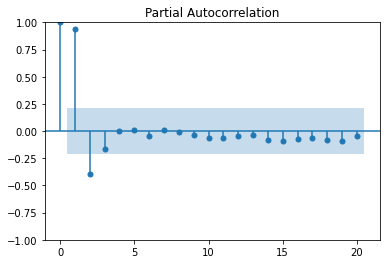

In [8]:
# Find the q, MA-term
plot_acf(Index_df_per_dag, lags=len(Index_df_per_dag)-1)

# Find the p, AR-term --> 1 
plot_pacf(Index_df_per_dag)

plt.show()

### Gevonden parameters
----
Naar aanleiding van de bovenstaande grafieken zou de order van ARIMA er als volgt uit moeten zien:
* p &#8594; 4
* d &#8594; 0
* q &#8594; 1
    
Het packet pmdarima maakt het mogelijk de ARIMA-parameters (p,d,q) te bepalen aan de hand van een aantal parameters. In de voglende cel worden aan de hand van de module "auto_arima" de meest passende parameters bepaald.

In [9]:
def arimamodel(timeseriesarray):

    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=0, 
                              start_q=0,
                              test="adf",
                              d=None,
                              m=52,
                              approximation=True,
                              Seasonal=True,
                              trace=True)

    return autoarima_model

arimamodel(Index_df_per_dag)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=929.761, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=927.956, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=835.052, Time=1.21 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=867.914, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=928.992, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=834.086, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=835.052, Time=0.87 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=837.052, Time=1.50 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=832.344, Time=0.10 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=832.076, Time=1.89 sec
 ARIMA(2,1,0)(2,0,0)[52] intercept   : AIC=834.076, Time=18.61 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=834.076, Time=2.37 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=832.076, Time=1.54 sec
 ARIMA(2,1,0)(2,0,1)[52] intercept   : AIC=836.076, Time=25.45 sec
 ARIMA(3,1,0)(1,0,0)[52] interc

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

Uit de auto_arima-functie komen de volgende parameters:
* p &#8594; 2
* d &#8594; 1
* q &#8594; 1

Naast de standaard ARIMA-order is een optimale seasonal_order gegeven. De optimale seasonal order ziet er als volgt uit:
* P &#8594; 1
* D &#8594; 0
* Q &#8594; 0
* Periode &#8594; 52

De periode heeft de waarde 52 gekregen. Dit getal geeft het aantal stappen weer die nodig zijn om een seasonal period, in dit geval een jaar, te doorlopen. 

In de volgende cel wordt het ARIMA-model getraind.

Text(0, 0.5, 'Benodigde IC-capaciteit per maand.')

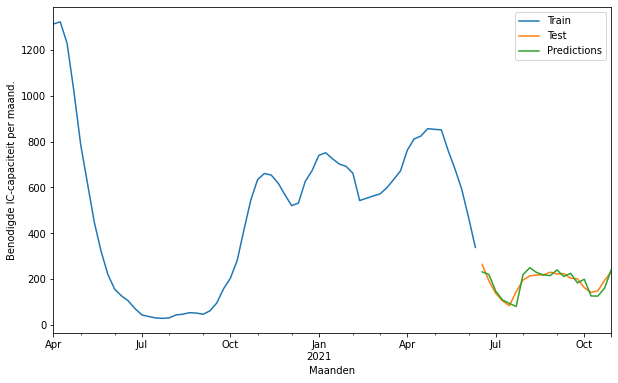

In [10]:
# Build model
model = ARIMA(Index_df_per_dag, order=(2,1,1)).fit()
pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))
model.summary()

# Plot results 
train.plot(legend=True, label="Train", figsize=(10,6))
test.plot(legend=True, label="Test")
pred.plot(legend=True, label="Predictions")
plt.xlabel("Maanden")
plt.ylabel("Benodigde IC-capaciteit per maand.")

In [11]:
# Get Metrics of the model
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mean absolute percentage error':mape, 'mean error':me, 'mean absolute error': mae, 
            'mean percentage error': mpe, 'root mean squarred error':rmse, 
            'correlation':corr, 'minmax':minmax})

forecast_accuracy(pred, test.values)

{'mean absolute percentage error': 0.11758211257945443,
 'mean error': -0.35584879951154563,
 'mean absolute error': 21.005389877518358,
 'mean percentage error': -0.0025927105567575136,
 'root mean squarred error': 25.3328227004351,
 'correlation': 0.8763394647428552,
 'minmax': 0.11097428283098343}

Uit de grafiek blijkt dat de predictiewaarden nagenoeg overeen komen met de testwaardes. **Iets schrijven over de metrics!** Hieruit lijkt vooralsnog het model adequaat te zijn. In de volgende cel wordt een predictie met behulp van ARIMA gemaakt die de IC-capaciteit per week tot en met 1 november 2022 voorspeld.

# Validate model with 2020 data
---
< Dit onderdeel moet nog verplaatst worden >

In [12]:
# Create Train and Test set
train_2020 = Index_df_per_dag[:39]
test_2021 = Index_df_per_dag[39:]

In [13]:
model_2020 = ARIMA(Index_df_per_dag, order=(2,1,1)).fit()

pred_2020 = model_2020.predict(start=len(train_2020), end=(len(Index_df_per_dag) -1))

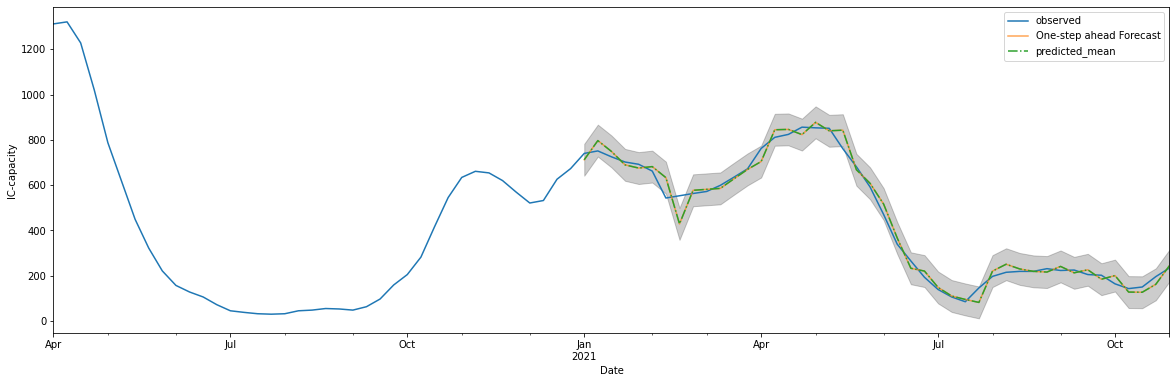

In [14]:
# Visualize predictions v.s. test values
pred = model_2020.get_prediction(start=pd.to_datetime('2021-01-03'), dynamic=False)
pred_ci = pred.conf_int()

# Plotting IC-capacity
ax = Index_df_per_dag['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20,6))
pred_2020.plot(ls="-.")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
plt.legend()

plt.show()

In [15]:
# Get the metrics of the model
forecast_accuracy(pred_2020, test_2021.values)

{'mean absolute percentage error': 0.08137538403375673,
 'mean error': 2.876671625783645,
 'mean absolute error': 27.12359416347956,
 'mean percentage error': 0.00452209467359605,
 'root mean squarred error': 36.27223641512748,
 'correlation': 0.9907819637605282,
 'minmax': 0.07703571584124969}

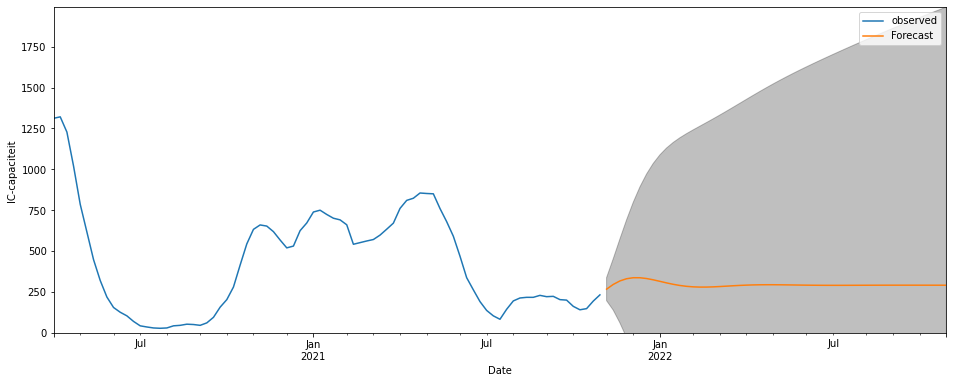

In [16]:
# Predict the future data.
final_model = ARIMA(Index_df_per_dag, order=(2,1,1)).fit()

prediction = final_model.predict(len(Index_df_per_dag), len(Index_df_per_dag) + 365)

# Dezelfde plot als bovenstaande cel, met onzekerheid.
# Get forecast 12 steps ahead in future
pred_uc = final_model.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the model
ax = Index_df_per_dag.plot(label='observed', figsize=(16,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capaciteit')
ax.set_ylim(0,pred_ci.iloc[:, 1].max())

plt.legend()
plt.show()

De predicties die vanuit het ARIMA-model naar voren zijn gekomen zijn te vinden in bovenstaande grafiek. Binnen de grafiek is te zien dat de oranje lijn (de voorspellingen, na februari 2022 afvlakken. Daarnaast is te zien dat het onzekere gebied, het grijze vlak, steeds onzekerder wordt. Naar aanleiding [van het forum stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) lijkt de stagnering te komen doordat ARIMA geen rekening kan houden en daardoor seizoenen niet herkend. Een model dat hier wel rekening mee houdt is SARIMA. In de onderstaande cel wordt het SARIMA-model opgesteld.

In [17]:
mod = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(2,1,1),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

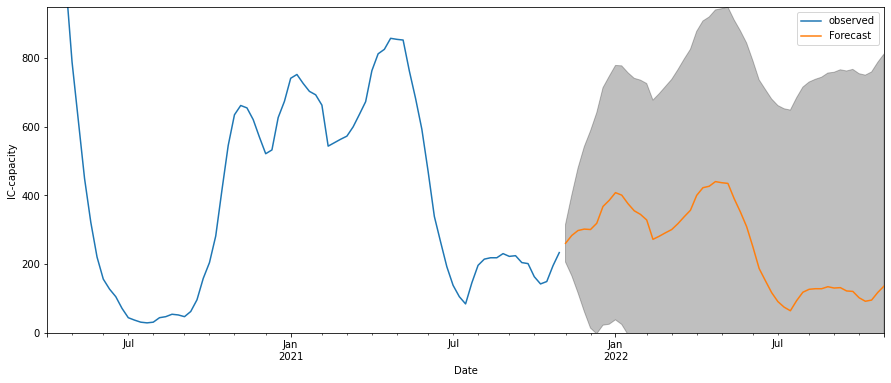

In [18]:
# Get forecast 52 steps ahead in future
pred_uc = results.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,pred_ci.iloc[:, 1].max())

plt.legend()
plt.show()

De IC-capaciteit die het SARIMA-model heeft voorspeld zijn te zien in bovenstaande grafiek. Naar aanleiding van de resultaten van het SARIMA-model blijkt de hypothese van [stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) klopt. De voorspellingen hebben namelijk meer variatie zien. Daarnaast is de onzekerheid (het grijze gebied) aanzienlijk kleiner is dan het geval is bij het ARIMA-model.

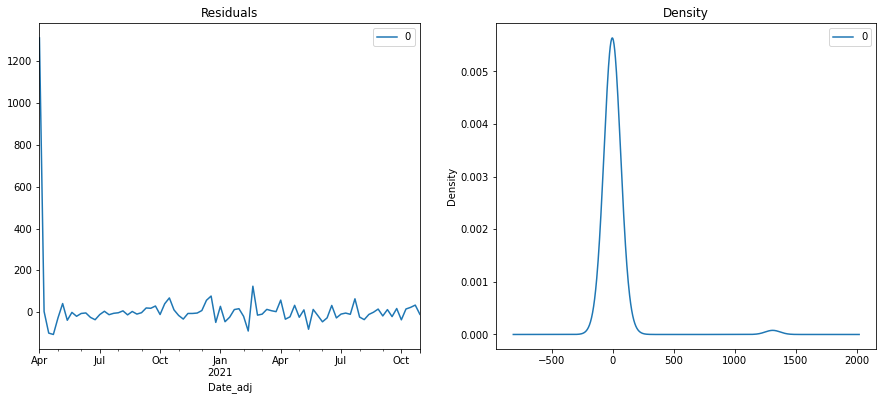

In [19]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2, figsize=(15,6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

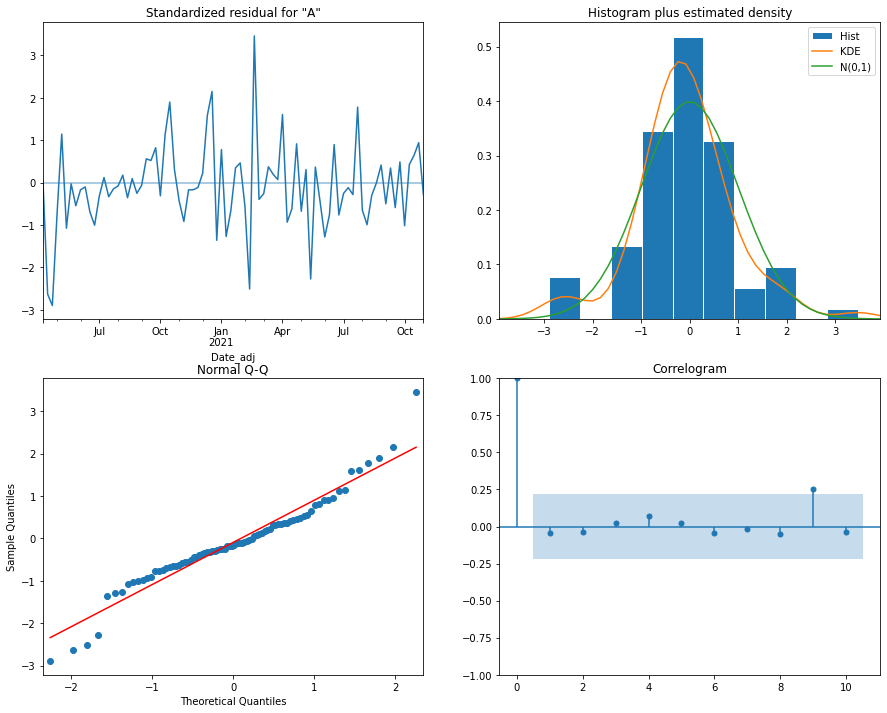

In [20]:
# Forecast testdata
final_model.plot_diagnostics(figsize=(15, 12))
plt.show()